In [1]:
from some import add_project_root_to_path

add_project_root_to_path()

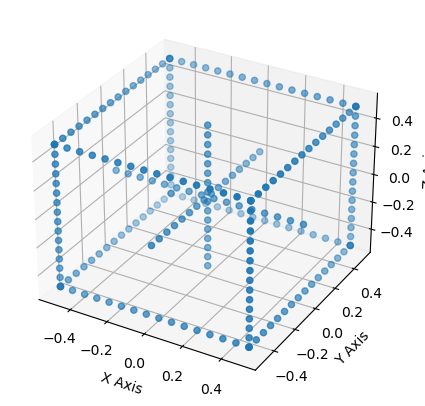

In [2]:
import numpy as np 
from utils.week1 import  PiInv, Pi,project_points,plot3d
from scipy.spatial.transform import Rotation


K = np.array([[1000,0,300],[0,1000,200],[0,0,1]])
R_1 = np.eye(3) 
t_1 = 0 

R_2 =  Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t_2 = np.array([0.2,2,1])



3.1 

In [3]:
Q = np.array([1,0.5,4,1])

q1   = Pi(K @ np.column_stack((R_1,np.array([0,0,0]))) @ (Q) )
q2 = Pi(K @ np.column_stack((R_2,t_2)) @ Q)


In [4]:
q1,q2

(array([550., 325.]), array([582.47256835, 185.98985776]))

In [5]:
R_1.T@ R_1

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## 3.2

In [6]:
def crossOp(p): 
    p_cross = np.array([[0,-p[2],p[1]],[p[2],0,-p[0]],[-p[1],p[0],0]]) 
    return p_cross

In [7]:
test_1 = np.array([2,4,6])
test_2 = np.array([3,6,8])

np.testing.assert_equal(np.cross(test_1,test_2),crossOp(test_1) @ test_2)

## Exercise 3.3
* Copmute the fundamental matrix of the two cameras 

In [8]:

E = crossOp(t_2) @ R_2

F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)

F


array([[ 3.29311881e-07,  8.19396327e-07,  1.79162592e-03],
       [ 5.15532551e-07, -8.76915984e-07,  9.31426656e-05],
       [-1.29882755e-03,  1.51951700e-03, -1.10072682e+00]])

## Exercise 3.4
* What is the epipolar line l of q1 in camera two?

q1

In [9]:
l = (F@PiInv(q1))

print(l)

[ 2.23905126e-03  9.16878739e-05 -1.32123895e+00]


## Exercise 3.5 
* Is q2 located on the epipolar line from Exercise 3.4? Do the computations, but also explain why
this must be so.

In [10]:
PiInv(q2.T) @ l

4.440892098500626e-16

## ex 3.8



In [11]:
data = np.load('../Data/TwoImageDataCar.npy',allow_pickle=True).item()

In [12]:
data.keys()

dict_keys(['im1', 'R1', 't1', 'im2', 'R2', 't2', 'K'])

In [13]:
K = data["K"] 

im1 = data["im1"]
R1 = data["R1"]
t1 = data["t1"] 
im2 = data["im2"]
R2 = data["R2"]
t2 = data["t2"] 

In [14]:
E = crossOp(t1) @ R1
F = np.transpose(np.linalg.inv(K)) @ E @ np.linalg.inv(K) 
F

array([[-1.94029315e-08, -1.26535831e-06,  1.42215454e-05],
       [-1.74360791e-06, -3.16893157e-07, -1.20302873e-03],
       [-5.87867477e-05,  2.78146673e-03, -1.01653094e-01]])

In [15]:
E = crossOp(t1) @ R1
F = np.transpose(np.linalg.inv(K)) @ E @ np.linalg.inv(K) 

In [16]:
import matplotlib.pyplot as plt 

def show2imgs(im1,im2):
    ig,ax = plt.subplots(1,2,figsize=(10,10))
    
    ax[0].imshow(im1)
    ax[1].imshow(im2) 
    x = plt.ginput(1)
    plt.show()
    point = np.array(x).reshape(-1,1)
    return point


def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
          return q
        
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

In [18]:

def ex9(im1,im2,K,R1,R2,t1,t2):
    q1_ = show2imgs(im1,im2)

    
    E = crossOp(t1) @ R1 

    F = np.linalg.inv(K).T @ E @  np.linalg.inv(K) 



    l = F @ PiInv(q1_)
    shape = im2.shape
    
    DrawLine(l,shape)

    return F



In [19]:
F = ex9(im1,im2,K,R1,R2,t1,t2)

QSocketNotifier: Can only be used with threads started with QThread
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

# Exercise 3.11

In [20]:
def triangulate(qn,pn):
    """ 
    input:list of points qn and projection matrices Pn"""
    if len(qn) != len(pn):
        raise ValueError("Expected lists of equal length, len(Q)!=len(pn)")


    
    
    B_i = lambda P,q: np.array([  [P[2]*q[0] - P[0]],[P[2]*q[1] - P[1]]  ])

    B = np.hstack(([B_i(P_i,Pi(q_i)) for P_i, q_i in zip(pn,qn)]))

    B = B.reshape(len(pn)*2,4)
    U,S,VT = np.linalg.svd(B)

    Q = VT[-1,:]
    return Q


# Quizz 3 



In [21]:
import cv2 
import numpy as np 


K = np.array([[900, 0, 1070], [0, 900, 610.0], [0, 0, 1]], float)
R1 = cv2.Rodrigues(np.array([-1.6, 0.3, -2.1]))[0]
t1 = np.array([[0.0], [1.0], [3.0]], float)
R2 = cv2.Rodrigues(np.array([-0.4, -1.3, -1.6]))[0]
t2 = np.array([[0.0], [1.0], [6.0]], float)
R3 = cv2.Rodrigues(np.array([2.5, 1.7, -0.4]))[0]
t3 = np.array([[2.0], [-7.0], [25.0]], float)


#Observed points 

p1 = np.array([[1046.0], [453.0]])
p2 = np.array([[1126.0], [671.0]])
p3 = np.array([[1165.0], [453.0]])


Q = [p1,p2,p3]
P1 = K@ np.column_stack((R1,t1))
P2 = K @ np.column_stack((R2,t2))
P3 = K @ np.column_stack((R3,t3)) 


Pi(triangulate(Q,[P1,P2,P3]))

array([3.10058867, 0.74321098, 0.46490561])

In [22]:
E = crossOp(t1.flatten())  @ R1
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
l1 = F @ PiInv(p1)

In [23]:
def shortest_distance(p1,l):
    d = np.abs(l.T@p1)/(np.abs(p1[2])*(np.sqrt(l[0]**2+l[1]**2)))
    return d

In [24]:
PiInv(p2).T @ l1

array([[-0.75727712]])

: 